# In this variant i tried to test IHC and H&E images separately on HER2 scoring to see the results. in this notebook i switch to the 80 20 split to see how the results improve

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [15]:
import os
import csv
from PIL import Image
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
import torch
import torch.nn as nn
from torchvision import models
import torch.optim as optim
from torch.cuda.amp import GradScaler, autocast
from torch.optim import Adam

from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, roc_curve, auc

import pandas as pd
from torch.utils.data import Dataset
from torchvision import transforms
from sklearn.metrics import accuracy_score, f1_score, classification_report
from sklearn.metrics import precision_recall_fscore_support


In [4]:
def write_csv_from_folder(folder_path, csv_file_path):
    # List all files in the given folder
    files = os.listdir(folder_path)

    with open(csv_file_path, mode='w', newline='') as file:
        writer = csv.writer(file)
        writer.writerow(['id', 'her2_score'])  # Writing the header
        existing_rows = []
        for filename in files:
            # Split the filename to extract the ID and the HER2 score
            # Example filename: "12345_train_2.jpg"
            parts = filename.split('_')
            if len(parts) < 3:
                print("Skipped image")
                continue  # Skip files that don't match the expected pattern
            image_id = parts[0]
            her2_score = parts[2].split('.')[0][0]  # Remove the file extension and get the score
            row = [image_id, her2_score]
            if row not in existing_rows:
                writer.writerow(row)
                existing_rows.append(row)

# Define the paths to the train and test folders
train_IHC_folder_path = '/content/drive/MyDrive/Final Project/BCI_dataset/IHC/train'
train_HE_folder_path = '/content/drive/MyDrive/Final Project/BCI_dataset/HE/train'
test_IHC_folder_path = '/content/drive/MyDrive/Final Project/BCI_dataset/IHC/test'
test_HE_folder_path = '/content/drive/MyDrive/Final Project/BCI_dataset/HE/test'

# Define the paths for the output CSV files
train_IHC_csv_path = 'train_IHC_data.csv'
train_HE_csv_path = 'train_HE_data.csv'
test_IHC_csv_path = 'test_IHC_data.csv'
test_HE_csv_path = 'test_HE_data.csv'

# Process the train and test folders and write to CSV files
write_csv_from_folder(train_IHC_folder_path, train_IHC_csv_path)
write_csv_from_folder(train_HE_folder_path, train_HE_csv_path)

write_csv_from_folder(test_IHC_folder_path, test_IHC_csv_path)
write_csv_from_folder(test_HE_folder_path, test_HE_csv_path)

row_count_train = 0
row_count_test = 0

# with open(train_csv_path) as f:
#     row_count_train = sum(1 for line in f)

# with open(test_csv_path) as f:
#     row_count_test = sum(1 for line in f)



# print("CSV files have been created.")
# print(f"Train dataset lenght = {row_count_train}")
# print(f"Test dataset lenght = {row_count_test}")

In [5]:

class HER2Dataset(Dataset):
    def __init__(self, root_dir, labels_file, transform=None):
        """
        Args:
            root_dir (string): Directory with all the image pairs.
            labels_file (string): Path to the CSV file with labels.
            transform (callable, optional): Optional transform to be applied on a sample.
        """
        self.root_dir = root_dir
        self.labels = pd.read_csv(labels_file)
        self.transform = transform
        self.images =  os.listdir(root_dir)

        for img in self.images:
          if "(1)" in img:
            self.images.remove(img)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img = self.images[idx]
        image = Image.open(os.path.join(self.root_dir, img)).convert("RGB")

        if self.transform:
            image = self.transform(image)

        label = self.labels.iloc[idx]['her2_score']  # Assuming 'her2_score' column in CSV

        return image, label  # Return both images and the label

# Example of setting up the dataset with transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])
dataset_he_train = HER2Dataset(root_dir='/content/drive/MyDrive/Final Project/BCI_dataset/HE/train', labels_file='train_HE_data.csv', transform=transform)
dataset_ihc_train = HER2Dataset(root_dir='/content/drive/MyDrive/Final Project/BCI_dataset/IHC/train', labels_file='train_IHC_data.csv', transform=transform)
dataset_he_test = HER2Dataset(root_dir='/content/drive/MyDrive/Final Project/BCI_dataset/HE/test', labels_file='test_HE_data.csv', transform=transform)
dataset_ihc_test = HER2Dataset(root_dir='/content/drive/MyDrive/Final Project/BCI_dataset/IHC/test', labels_file='test_IHC_data.csv', transform=transform)

In [6]:
# Load the CSV file into a DataFrame
df = pd.read_csv('train_IHC_data.csv')

# Count the instances in each class for the 'her2_score' column
class_counts = df['her2_score'].value_counts()

# Display the counts
print(class_counts)

her2_score
2    1697
3    1078
1     919
0     202
Name: count, dtype: int64


In [7]:
# Load the CSV file into a DataFrame
df = pd.read_csv('train_HE_data.csv')

# Count the instances in each class for the 'her2_score' column
class_counts = df['her2_score'].value_counts()

# Display the counts
print(class_counts)

her2_score
2    1697
3    1078
1     919
0     202
Name: count, dtype: int64


In [8]:
# Load the CSV file into a DataFrame
df = pd.read_csv('test_IHC_data.csv')

# Count the instances in each class for the 'her2_score' column
class_counts = df['her2_score'].value_counts()

# Display the counts
print(class_counts)

her2_score
2    446
3    258
1    235
0     38
Name: count, dtype: int64


In [9]:
# Load the CSV file into a DataFrame
df = pd.read_csv('test_HE_data.csv')

# Count the instances in each class for the 'her2_score' column
class_counts = df['her2_score'].value_counts()

# Display the counts
print(class_counts)

her2_score
2    446
3    258
1    235
0     38
Name: count, dtype: int64


Class Distribution Plots

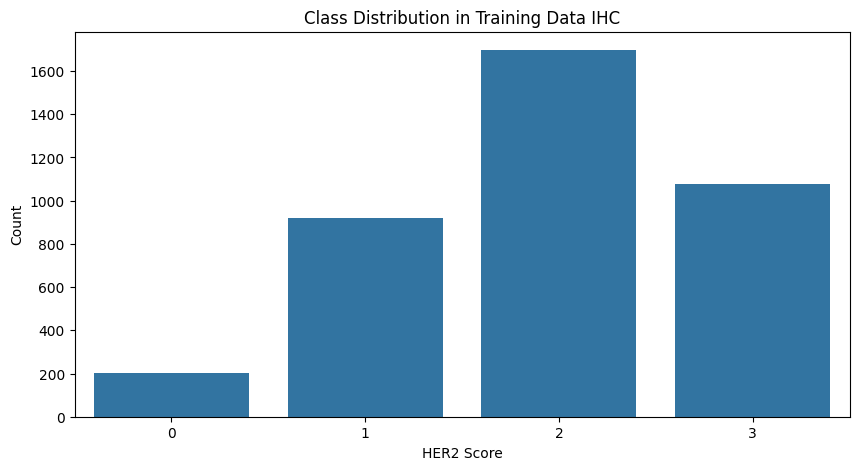

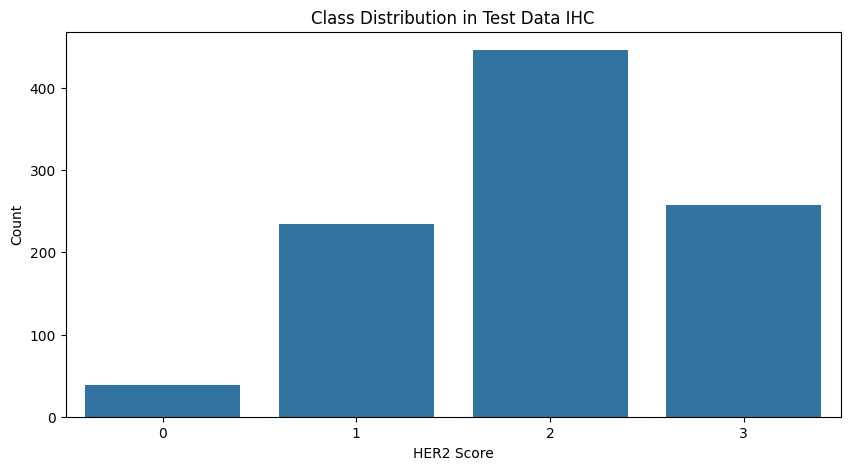

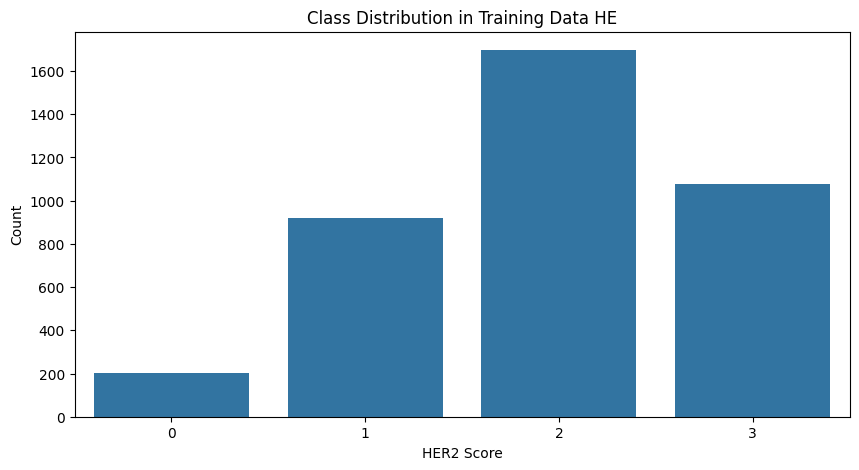

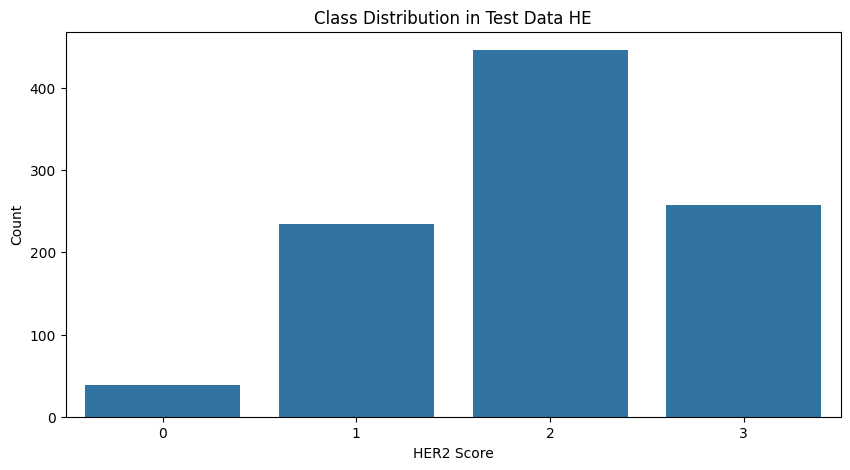

In [10]:
df_train_IHC = pd.read_csv('train_IHC_data.csv')
df_test_IHC = pd.read_csv('test_IHC_data.csv')

df_train_HE = pd.read_csv('train_HE_data.csv')
df_test_HE = pd.read_csv('test_HE_data.csv')

plt.figure(figsize=(10, 5))
sns.countplot(x='her2_score', data=df_train_IHC)
plt.title('Class Distribution in Training Data IHC')
plt.xlabel('HER2 Score')
plt.ylabel('Count')
plt.show()

plt.figure(figsize=(10, 5))
sns.countplot(x='her2_score', data=df_test_IHC)
plt.title('Class Distribution in Test Data IHC')
plt.xlabel('HER2 Score')
plt.ylabel('Count')
plt.show()

plt.figure(figsize=(10, 5))
sns.countplot(x='her2_score', data=df_train_HE)
plt.title('Class Distribution in Training Data HE')
plt.xlabel('HER2 Score')
plt.ylabel('Count')
plt.show()

plt.figure(figsize=(10, 5))
sns.countplot(x='her2_score', data=df_test_HE)
plt.title('Class Distribution in Test Data HE')
plt.xlabel('HER2 Score')
plt.ylabel('Count')
plt.show()


In [11]:
# Define the model
class ResNetClassifier(nn.Module):
    def __init__(self, num_classes=4):
        super(ResNetClassifier, self).__init__()
        self.resnet = models.resnet18(pretrained=True)
        self.resnet.fc = nn.Linear(self.resnet.fc.in_features, num_classes)

    def forward(self, x):
        return self.resnet(x)

# Initialize model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_he = ResNetClassifier(num_classes=4).to(device)
model_ihc = ResNetClassifier(num_classes=4).to(device)


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 92.6MB/s]


In [12]:
losses_training = []
losses_validation = []
accuracies_training = []
accuracies_validation = []
num_epochs = 100

In [13]:
# Define the training loop
def train_model(model, train_loader, val_loader, criterion, optimizer, device, num_epochs=num_epochs):
    scaler = GradScaler()

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        total_correct = 0
        total_data_points = 0
        misclassified_details = {}


        for ids, (inputs, targets) in enumerate(train_loader):
            inputs, targets = inputs.to(device), targets.to(device)
            optimizer.zero_grad()
            with autocast():
                outputs = model(inputs)
                loss = criterion(outputs, targets)

            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

            running_loss += loss.item() * inputs.size(0)
            total_data_points += inputs.size(0)
            total_correct += (outputs.argmax(dim=1) == targets).sum().item()

            predictions = outputs.argmax(dim=1)
            for target, prediction in zip(targets, predictions):
                if target != prediction:
                    target_class = target.item()
                    pred_class = prediction.item()
                    if target_class not in misclassified_details:
                        misclassified_details[target_class] = []
                    misclassified_details[target_class].append(pred_class)



        # Print misclassified details for each class
        for cls, predictions in misclassified_details.items():
            print(f'Class {cls} misclassified {len(predictions)} times. Predicted as: {predictions}')


        accuracy = total_correct / total_data_points
        epoch_loss = running_loss / total_data_points
        losses_training.append(epoch_loss)
        print(f'Epoch {epoch+1}/{num_epochs}, Training Loss: {epoch_loss:.4f}, Accuracy: {accuracy:.4f}')
        accuracies_training.append(accuracy)
        validate_model(model, val_loader, criterion, device=device)


def validate_model(model, val_loader, criterion, device):
    model.eval()
    running_loss = 0.0
    total_correct = 0
    total_data_points = 0
    misclassified_details = {}

    y_true = []
    y_pred = []
    with torch.no_grad():
        for ids, (inputs, targets) in enumerate(val_loader):
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)

            running_loss += loss.item() * inputs.size(0)
            total_correct += (outputs.argmax(dim=1) == targets).sum().item()
            total_data_points += inputs.size(0)

            # Calculate misclassifications
            predictions = outputs.argmax(dim=1)
            for target, prediction in zip(targets, predictions):
                y_true.append(target.cpu().numpy())
                y_pred.append(prediction.cpu().numpy())
                if target != prediction:
                    target_class = target.item()
                    pred_class = prediction.item()
                    if target_class not in misclassified_details:
                        misclassified_details[target_class] = []
                    misclassified_details[target_class].append(pred_class)

    epoch_loss = running_loss / total_data_points
    accuracy = total_correct / total_data_points
    losses_validation.append(epoch_loss)
    accuracies_validation.append(accuracy)
    print(classification_report(y_true, y_pred))
    precision, recall, f1, support = precision_recall_fscore_support(y_true, y_pred, average='weighted')
    print(f'Precision: {precision:.4f}, Recall: {recall:.4f}, F1: {f1:.4f}, Support: {support}')

    print(f'Validation Loss: {epoch_loss:.4f}, Accuracy: {accuracy:.4f}')
    print(f'F1 Score: {f1}' )

    # Print misclassified details for each class
    for cls, predictions in misclassified_details.items():
        print(f'Class {cls} misclassified {len(predictions)} times. Predicted as: {predictions}')

    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()




# Prepare data loaders
train_loader = DataLoader(dataset_he_train, batch_size=10)
val_loader = DataLoader(dataset_he_test, batch_size=10)

# Initialize the model, criterion, and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = Adam(model_he.parameters(), lr=0.001)




In [ ]:
# model.load_state_dict(torch.load('/content/drive/MyDrive/Final Project/model.pth'))
# model.eval()

In [29]:
train_model(model_he, train_loader, val_loader, criterion, optimizer, device=device, num_epochs=num_epochs)

Output hidden; open in https://colab.research.google.com to view.

Losses plots

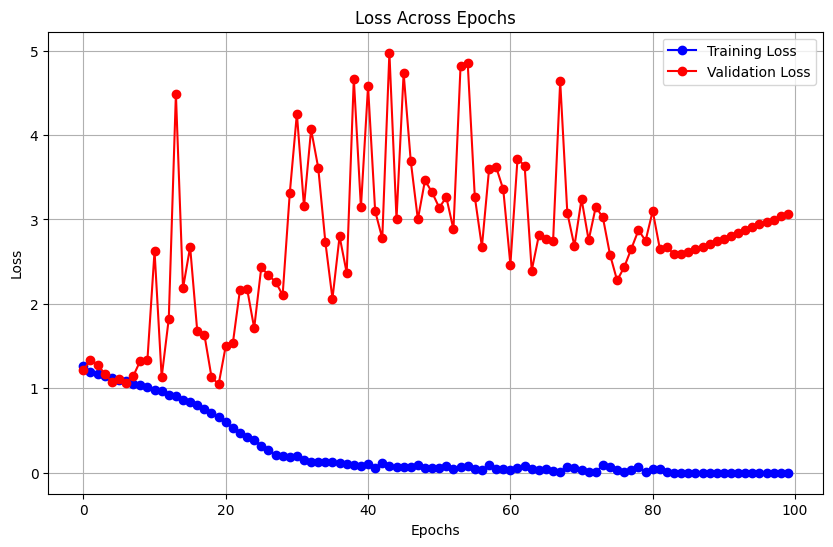

In [30]:
plt.figure(figsize=(10, 6))
plt.plot(range(num_epochs), losses_training, marker='o', linestyle='-', color='b', label='Training Loss')
plt.plot(range(num_epochs), losses_validation, marker='o', linestyle='-', color='r', label='Validation Loss')
plt.title('Loss Across Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

Accuracies Plots


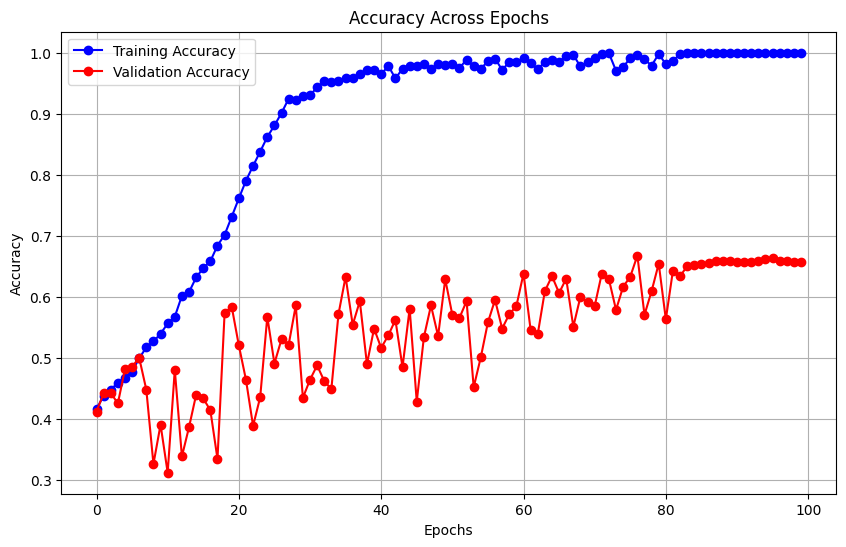

In [31]:
plt.figure(figsize=(10, 6))
plt.plot(range(num_epochs), accuracies_training, marker='o', linestyle='-', color='b', label='Training Accuracy')
plt.plot(range(num_epochs), accuracies_validation, marker='o', linestyle='-', color='r', label='Validation Accuracy')
plt.title('Accuracy Across Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

In [32]:
val_loader = DataLoader(dataset_he_train, batch_size=1)

def load_image(image_path):
    image = Image.open(image_path).convert('RGB')  # Load image and convert to RGB
    image = transform(image)  # Apply transformations
    return image

def get_sample_predictions(root_dir, model, n_iter, device):
    model.eval()
    sample_images = []
    sample_true_labels = []  # This should be provided along with the image paths
    sample_pred_labels = []
    counter = 0
    with torch.no_grad():
        for image_path in os.listdir(root_dir):
            image = load_image(root_dir + image_path)
            input = image.to(device).unsqueeze(0)  # Add batch dimension and move to device
            output = model(input)
            pred_label = output.argmax(dim=1).item()

            sample_images.append(image.cpu().squeeze(0))  # Move to CPU and remove batch dimension
            sample_pred_labels.append(pred_label)
            parts = image_path.split('_')
            true_label = parts[2].split('.')[0][0]  # Remove the file extension and get the score
            sample_true_labels.append(true_label)
            counter +=1
            if counter == n_iter:
              break
    return sample_images, sample_true_labels, sample_pred_labels

# def get_sample_predictions(num_samples, val_dataloader, model):
#   sample_images = []
#   sample_true_labels = []
#   sample_pred_labels = []
#   counter = 0
#   for ids, (inputs, targets) in enumerate(val_dataloader):
#     inputs, targets = inputs.to(device), targets.to(device)
#     outputs = model(inputs)
#     image = inputs.squeeze()
#     if counter == num_samples:
#       break
#     else:
#       counter += 1

#   for i in range(num_samples):
#     train_features, train_labels = next(iter(val_dataloader))
#     img = train_features[0].squeeze()
#     label = train_labels[0]

#   return sample_images, sample_true_labels, sample_pred_labels


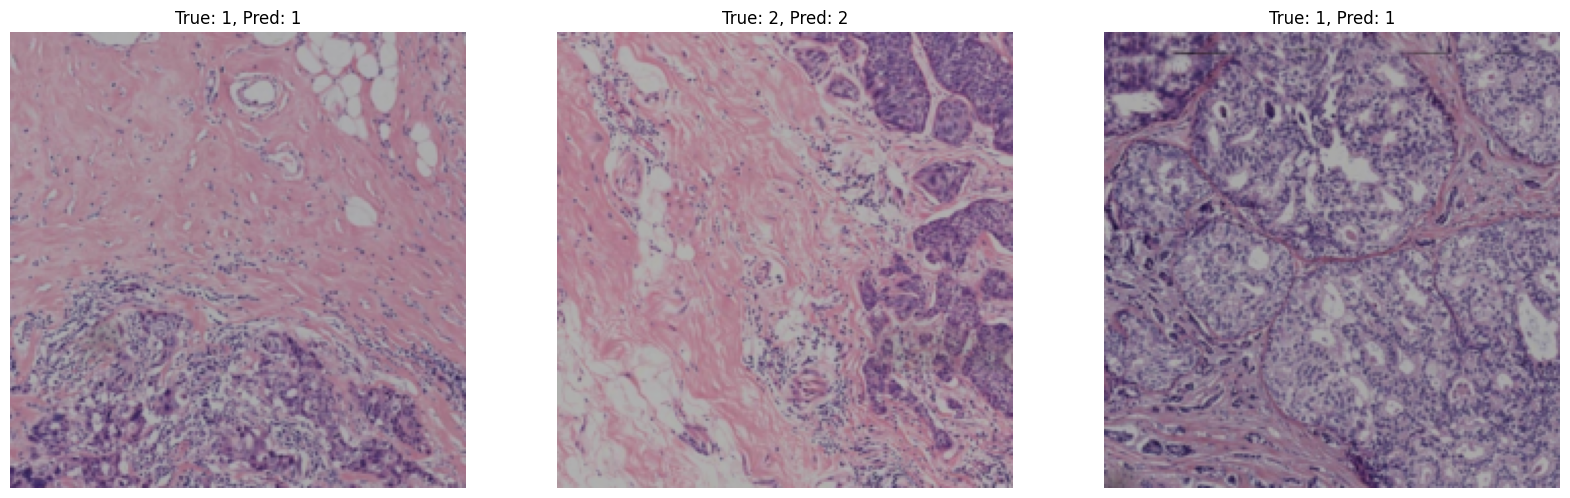

In [33]:
n_sample_plots = 3

sample_images, sample_true_labels, sample_pred_labels = get_sample_predictions('/content/drive/MyDrive/Final Project/BCI_dataset/HE/train/', model_he, n_sample_plots, device)

plt.figure(figsize=(20, 10))
for i in range(len(sample_images)):
    plt.subplot(1 , len(sample_images), i+1)
    plt.imshow(sample_images[i].permute(1, 2, 0))  # Assuming images are in CHW format
    plt.title(f'True: {sample_true_labels[i]}, Pred: {sample_pred_labels[i]}')
    plt.axis('off')
plt.show()

In [34]:
torch.save(model_ihc.state_dict(), '/content/drive/MyDrive/Final Project/model_only_he_80_20_100epochs.pth')

# Second model

In [16]:
losses_training = []
losses_validation = []
accuracies_training = []
accuracies_validation = []


# Prepare data loaders
train_loader = DataLoader(dataset_ihc_train, batch_size=10)
val_loader = DataLoader(dataset_ihc_test, batch_size=10)
optimizer = Adam(model_ihc.parameters(), lr=0.001)

train_model(model_ihc, train_loader, val_loader, criterion, optimizer, device=device, num_epochs=num_epochs)


Output hidden; open in https://colab.research.google.com to view.

In [17]:
torch.save(model_ihc.state_dict(), '/content/drive/MyDrive/Final Project/model_only_ihc_80_20_100epochs.pth')

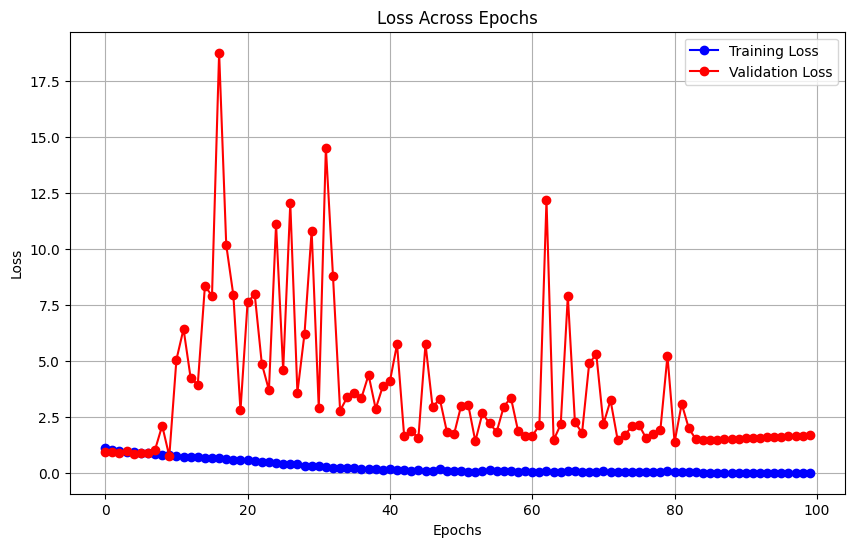

In [18]:
plt.figure(figsize=(10, 6))
plt.plot(range(num_epochs), losses_training, marker='o', linestyle='-', color='b', label='Training Loss')
plt.plot(range(num_epochs), losses_validation, marker='o', linestyle='-', color='r', label='Validation Loss')
plt.title('Loss Across Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

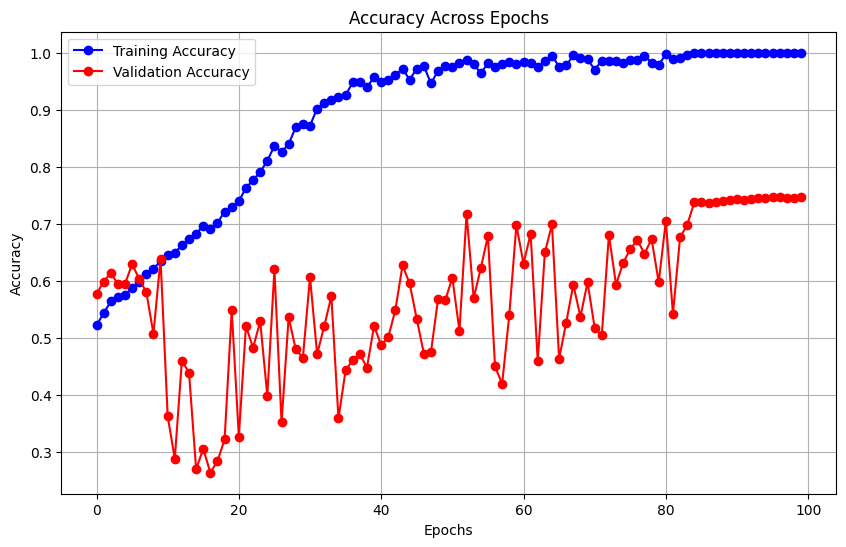

In [19]:
plt.figure(figsize=(10, 6))
plt.plot(range(num_epochs), accuracies_training, marker='o', linestyle='-', color='b', label='Training Accuracy')
plt.plot(range(num_epochs), accuracies_validation, marker='o', linestyle='-', color='r', label='Validation Accuracy')
plt.title('Accuracy Across Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

In [20]:
val_loader = DataLoader(dataset_ihc_train, batch_size=1)

In [21]:
n_sample_plots = 3

sample_images, sample_true_labels, sample_pred_labels = get_sample_predictions('/content/drive/MyDrive/Final Project/BCI_dataset/IHC/train/', model_ihc, n_sample_plots, device)

plt.figure(figsize=(20, 10))
for i in range(len(sample_images)):
    plt.subplot(1 , len(sample_images), i+1)
    plt.imshow(sample_images[i].permute(1, 2, 0))  # Assuming images are in CHW format
    plt.title(f'True: {sample_true_labels[i]}, Pred: {sample_pred_labels[i]}')
    plt.axis('off')
plt.show()

NameError: name 'get_sample_predictions' is not defined